<a href="https://colab.research.google.com/github/ZEY0D/schiesser-antibody-modeling/blob/main/Last_updated_dl_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Import* necessary libraries

In [ ]:

import torch
import torch.nn as nn
import torch.autograd as autograd
import pandas as pd
import time
import matplotlib.pyplot as plt


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Parameters Decleration from the reference

In [ ]:
# Parameters
kf = 1.0e5         # Forward rate constant
kr = 1.0e1        # Reverse rate constant
cb_sat = 1.66e-9   # Saturation concentration
D = 1e-10           # Diffusion coefficient
L = 5.0e-5         # Domain length
T = 100.0          # Final time
cbulk = 4.48e-5

# Collocation, boundary, and initial condition points
N_f, N_b, N_ic = 10000, 200, 200

Inputs normalization

In [ ]:

normalize_z = lambda z: z / L
normalize_t = lambda t: t / T

def rescale_c(c): return c * cbulk
def rescale_theta(th): return th * 0.295

# range control
def clamp01(x): return torch.clamp(x, 0.0, 1.0)

Neuaral networks declaration and models initialization

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, z, t):
        z_n = normalize_z(z)
        t_n = normalize_t(t)
        input = torch.cat([z_n, t_n], dim=1)
        return cbulk * self.net(input)


class ThetaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t):
        t_n = normalize_t(t)
        return 0.295 * torch.sigmoid(self.net(t_n))

model_c = PINN().to(device)
model_theta = ThetaNet().to(device)

random sample Training data

In [ ]:

z_f = torch.rand(N_f, 1).to(device) * L
t_f = torch.rand(N_f, 1).to(device) * (T - 1.0) + 1.0

z0 = torch.zeros(N_b, 1).to(device)
zL = torch.ones(N_b, 1).to(device) * L
t_b = torch.linspace(0, T, N_b).view(-1, 1).to(device)

# using adam optimizer
optimizer = torch.optim.Adam(list(model_c.parameters()) + list(model_theta.parameters()), lr=1e-3)

function ro calculate the overall losses

In [ ]:
def loss_fn():
    z_f_, t_f_ = z_f.clone().detach().requires_grad_(True), t_f.clone().detach().requires_grad_(True)
    c = model_c(z_f_, t_f_)
    c_z = autograd.grad(c, z_f_, grad_outputs=torch.ones_like(c), retain_graph=True, create_graph=True)[0]
    c_zz = autograd.grad(c_z, z_f_, grad_outputs=torch.ones_like(c_z), retain_graph=True, create_graph=True)[0]
    c_t = autograd.grad(c, t_f_, grad_outputs=torch.ones_like(c), retain_graph=True, create_graph=True)[0]
    pde_res = c_t - D * c_zz

    # Boundary at z=L
    cL = model_c(zL, t_b)
    cL_target = torch.full_like(cL, cbulk)

    # Theta dynamics
    t_b_ = t_b.clone().detach().requires_grad_(True)
    theta = model_theta(t_b_)
    dtheta_dt = autograd.grad(theta, t_b_, grad_outputs=torch.ones_like(theta), create_graph=True)[0]
    c0 = model_c(z0, t_b_)
    reaction_rate = kf * c0 * (1 - theta / 0.295) - kr * theta / 0.295
    ode_res = dtheta_dt - reaction_rate
    # Terminal loss
    theta_final = model_theta(torch.tensor([[T]]).float().to(device))
    theta_target = torch.tensor([[0.295]]).float().to(device)
    loss_terminal = torch.mean((theta_final - theta_target) ** 2)

    # Total loss
    loss_pde = torch.mean(pde_res**2)
    loss_bc = torch.mean((cL - cL_target)**2)
    loss_ode = torch.mean(ode_res**2)

    total_loss = loss_pde + loss_bc + loss_ode + 10.0 * loss_terminal
    return total_loss, loss_pde.item(), loss_bc.item(), loss_ode.item(), loss_terminal.item()

Training loop on 5000 epochs with calculating overall training time

In [ ]:
start_time = time.time()

for epoch in range(5001):
    optimizer.zero_grad()
    loss_total, l_pde, l_bc, l_ode, l_term = loss_fn()
    loss_total.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss_total.item():.3e} | PDE: {l_pde:.2e}, BC: {l_bc:.2e}, ODE: {l_ode:.2e}, Term: {l_term:.2e}")

end_time = time.time()
print(f"\nTraining completed in {end_time - start_time:.2f} seconds.")

Epoch 0, Loss: 8.517e-01 | PDE: 1.60e-14, BC: 5.77e-10, ODE: 3.98e-01, Term: 4.54e-02
Epoch 100, Loss: 3.862e-01 | PDE: 1.55e-13, BC: 9.08e-11, ODE: 1.15e-02, Term: 3.75e-02
Epoch 200, Loss: 2.899e-01 | PDE: 5.39e-13, BC: 2.00e-10, ODE: 1.85e-02, Term: 2.71e-02
Epoch 300, Loss: 2.208e-01 | PDE: 1.08e-12, BC: 1.18e-09, ODE: 1.66e-02, Term: 2.04e-02
Epoch 400, Loss: 1.677e-01 | PDE: 1.75e-12, BC: 3.29e-09, ODE: 9.73e-03, Term: 1.58e-02
Epoch 500, Loss: 1.289e-01 | PDE: 2.58e-12, BC: 6.61e-09, ODE: 2.92e-03, Term: 1.26e-02
Epoch 600, Loss: 1.032e-01 | PDE: 3.62e-12, BC: 1.08e-08, ODE: 1.03e-03, Term: 1.02e-02
Epoch 700, Loss: 8.565e-02 | PDE: 4.75e-12, BC: 1.54e-08, ODE: 5.68e-04, Term: 8.51e-03
Epoch 800, Loss: 7.327e-02 | PDE: 5.98e-12, BC: 1.98e-08, ODE: 4.77e-04, Term: 7.28e-03
Epoch 900, Loss: 6.419e-02 | PDE: 7.41e-12, BC: 2.38e-08, ODE: 4.51e-04, Term: 6.37e-03
Epoch 1000, Loss: 5.725e-02 | PDE: 9.25e-12, BC: 2.70e-08, ODE: 4.25e-04, Term: 5.68e-03
Epoch 1100, Loss: 5.175e-02 | PDE

solution data from reference to calculate error metrics

In [ ]:
# Reference data from Schiesser Table 2.3
ref_data = {
    't':  [0, 2, 4, 6, 8, 10, 90, 92, 94, 96, 98, 100],
    'c0': [0.00000e+00, 3.735e-07, 3.050e-06, 7.035e-06, 1.121e-05, 1.516e-05,
           4.470e-05, 4.472e-05, 4.473e-05, 4.474e-05, 4.474e-05, 4.475e-05],
    'cb': [0.00000e+00, 5.121e-12, 4.645e-11, 1.063e-10, 1.648e-10, 2.165e-10,
           5.127e-10, 5.129e-10, 5.130e-10, 5.131e-10, 5.131e-10, 5.132e-10],
    'theta': [0.00000e+00, 3.085e-03, 2.798e-02, 6.403e-02, 9.927e-02, 1.304e-01,
              3.089e-01, 3.089e-01, 3.090e-01, 3.091e-01, 3.091e-01, 3.092e-01],
    'rate': [0.00000e+00, 1.060e-11, 2.772e-11, 3.014e-11, 2.757e-11, 2.301e-11,
             1.430e-12, 1.262e-12, 8.640e-13, 4.094e-13, 2.026e-13, 3.637e-14]
}
df_ref = pd.DataFrame(ref_data)
t_ref = torch.tensor(df_ref['t'].values, dtype=torch.float32).view(-1, 1).to(device)
t_ref_normalized = t_ref / T  # Normalization for the reference data


Evaluation cell and calculating the needed parameters

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Evaluation on full spatiotemporal grid for c(z,t)
model_c.eval()
model_theta.eval()

t_eval = torch.linspace(0, T, 200).view(-1, 1).to(device)
z_eval = torch.linspace(0, L, 200).view(-1, 1).to(device)
T_grid, Z_grid = torch.meshgrid(t_eval.squeeze(), z_eval.squeeze(), indexing='ij')
t_flat, z_flat = T_grid.reshape(-1, 1), Z_grid.reshape(-1, 1)

with torch.no_grad():
    c_pred_flat = model_c(z_flat, t_flat)
    c_pred = c_pred_flat.view(200, 200).cpu().numpy()

# 2. Evaluate key quantities at reference times
with torch.no_grad():
    z0_ref = torch.zeros_like(t_ref).to(device)
    c0_pred = model_c(z0_ref, t_ref).cpu().numpy().flatten()
    theta_pred = model_theta(t_ref).cpu().numpy().flatten()
    cb_pred = theta_pred * cb_sat
    rate_pred = kf * c0_pred * (1 - theta_pred / 0.295) - kr * theta_pred / 0.295

# 3. Ground truth from Schiesser's table
c0_true = df_ref['c0'].values
cb_true = df_ref['cb'].values
theta_true = df_ref['theta'].values
rate_true = df_ref['rate'].values

# 4. Error metrics
def compute_errors(pred, true):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    maxerr = np.max(np.abs(true - pred))
    return mae, rmse, maxerr

metrics = {
    "c(0,t)": compute_errors(c0_pred, c0_true),
    "cb(t)": compute_errors(cb_pred, cb_true),
    "theta(t)": compute_errors(theta_pred, theta_true),
    "rate(t)": compute_errors(rate_pred, rate_true),
}

# 5. Print error table
print("\n🔎 Error Metrics Compared to Schiesser Reference:")
print(f"{'Quantity':<10} | {'MAE':>10} | {'RMSE':>10} | {'MaxErr':>10}")
print("-" * 45)
for key, (mae, rmse, maxerr) in metrics.items():
    print(f"{key:<10} | {mae:10.3e} | {rmse:10.3e} | {maxerr:10.3e}")



🔎 Error Metrics Compared to Schiesser Reference:
Quantity   |        MAE |       RMSE |     MaxErr
---------------------------------------------
c(0,t)     |  6.119e-04 |  6.197e-04 |  7.104e-04
cb(t)      |  2.008e-10 |  2.403e-10 |  4.055e-10
theta(t)   |  1.209e-01 |  1.448e-01 |  2.443e-01
rate(t)    |  7.099e-03 |  8.566e-03 |  1.292e-02


plotting all the results

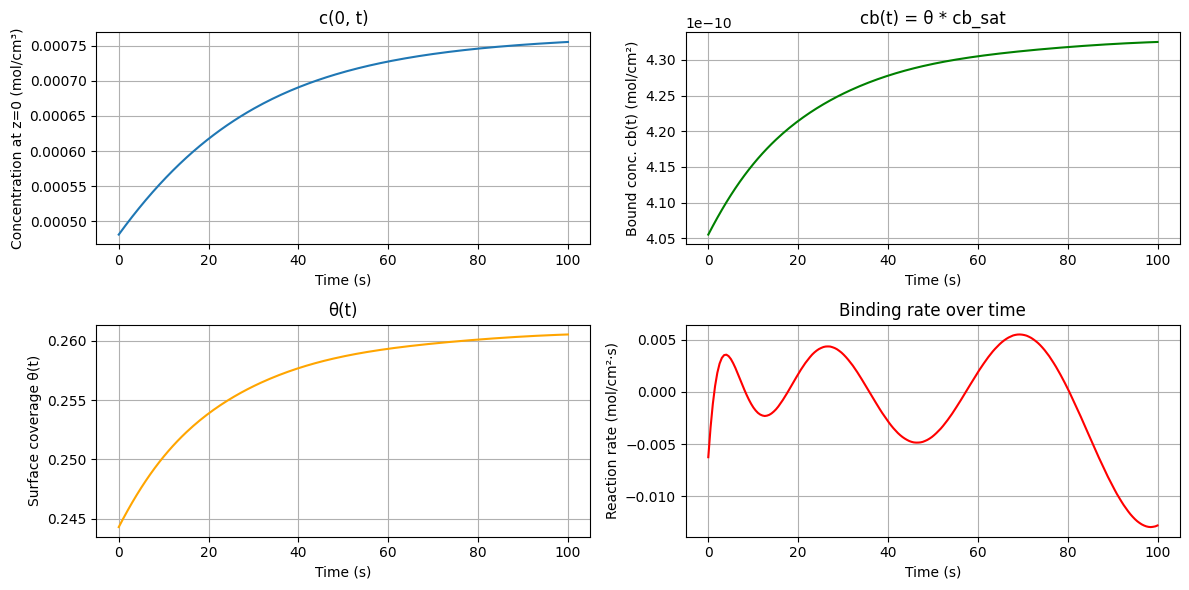

In [ ]:
# Plot c(0, t)
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(t_eval.cpu(), c0, label="c(0, t)")
plt.xlabel("Time (s)")
plt.ylabel("Concentration at z=0 (mol/cm³)")
plt.title("c(0, t)")
plt.grid(True)

# Plot cb(t)
plt.subplot(2, 2, 2)
plt.plot(t_eval.cpu(), cb, label="cb(t)", color='green')
plt.xlabel("Time (s)")
plt.ylabel("Bound conc. cb(t) (mol/cm²)")
plt.title("cb(t) = θ * cb_sat")
plt.grid(True)

# Plot θ(t)
plt.subplot(2, 2, 3)
plt.plot(t_eval.cpu(), theta, label="θ(t)", color='orange')
plt.xlabel("Time (s)")
plt.ylabel("Surface coverage θ(t)")
plt.title("θ(t)")
plt.grid(True)

# Plot rate(t)
plt.subplot(2, 2, 4)
plt.plot(t_eval.cpu(), rate, label="Rate(t)", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Reaction rate (mol/cm²·s)")
plt.title("Binding rate over time")
plt.grid(True)

plt.tight_layout()
plt.show()